In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch_lightning &> /dev/null

import torch
from torchvision import transforms
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.utils import draw_bounding_boxes
from PIL import ImageColor
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
from pytorch_lightning.loggers import tensorboard


use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
path = {}
path["images"] = "/content/drive/MyDrive/CIS 6800/SOLO dataset/hw3_mycocodata_img_comp_zlib.h5" 
path["labels"] = "/content/drive/MyDrive/CIS 6800/SOLO dataset/hw3_mycocodata_labels_comp_zlib.npy"
path["bboxes"] = "/content/drive/MyDrive/CIS 6800/SOLO dataset/hw3_mycocodata_bboxes_comp_zlib.npy"
path["masks"]  = "/content/drive/MyDrive/CIS 6800/SOLO dataset/hw3_mycocodata_mask_comp_zlib.h5"

In [4]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        #############################################
        # TODO Initialize  Dataset

        self.images = h5py.File(path["images"],'r')['data']
        self.masks = h5py.File(path["masks"],'r')['data']
        self.bboxes = np.load(path["bboxes"], allow_pickle=True)
        self.labels = np.load(path["labels"], allow_pickle=True)
        
        self.corresponding_masks = []
        # Aligning masks with labels
        count = 0
        for i, label in enumerate(self.labels):
            n = label.shape[0] 
            temp = []
            for j in range(n):
                temp.append(self.masks[count])
                count += 1
            self.corresponding_masks.append(temp)

        # Applying rescaling and mean, std, padding
        self.transform = torchvision.transforms.Compose([torchvision.transforms.Resize((800, 1066)), torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        self.resize = torchvision.transforms.Resize((800, 1066))
        self.pad = torch.nn.ZeroPad2d((11,11,0,0))

        #############################################


    # In this function for given index we rescale the image and the corresponding  masks, boxes
    # and we return them as output
    # output:
        # transed_img
        # label
        # transed_mask
        # transed_bbox
        # index
    def __getitem__(self, index):
        ################################
        # TODO return transformed images,labels,masks,boxes,index

        one_label = self.labels[index]
        one_image = self.images[index]
        one_bbox = self.bboxes[index]
        one_mask = self.corresponding_masks[index]

        one_label = torch.tensor(one_label)
        one_image, one_mask, one_bbox = self.pre_process_batch(one_image, one_mask, one_bbox)
        ################################

        assert one_image.shape == (3,800,1088)
        assert one_bbox.shape[0] == one_mask.shape[0]

        return one_image, one_label, one_mask, one_bbox, index
        

    # This function preprocess the given image, mask, box by rescaling them appropriately
    # output:
    #        img: (3,800,1088)
    #        mask: (n_box,800,1088)
    #        box: (n_box,4)
    def pre_process_batch(self, img, mask, box):
        #######################################
        # TODO apply the correct transformation to the images,masks,boxes

        img_normalized = img / 255.                     # Normalized between 0 & 1
        img_normalized = torch.tensor(img_normalized, dtype=torch.float)   # Converted to tensor
        img_scaled = self.transform(img_normalized)    # Rescaled to (800, 1066) and adjusted for given mean and std

        img_final = self.pad(img_scaled)              # Padded with zeros to get the shape as (800, 1088)

        msk_final = torch.zeros((len(mask), 800, 1088))           #Initializing mask tensor

        for i, msk in enumerate(mask):
            msk = msk/1.                                  # Converting it to uint8
            msk = torch.tensor(msk, dtype=torch.float).view(1,300,400)         # Converting it to tensor
            msk_scaled = self.pad(self.resize(msk).view(800,1066))            # Padding and resizing
            msk_scaled[msk_scaled < 0.5] = 0
            msk_scaled[msk_scaled > 0.5] = 1
            msk_final[i] = msk_scaled

        box = torch.tensor(box, dtype=torch.float)
        box_final = torch.zeros_like(box)
        box_final[:,1] = box[:,1] * 800/300                  # Scaling x
        box_final[:,3] = box[:,3] * 800/300                  # Scaling x
        box_final[:,0] = box[:,0] * (1066/400) + 11                # Scaling y
        box_final[:,2] = box[:,2] * (1066/400) + 11                # Scaling y
        
        return img_final, msk_final, box_final
        ######################################
    
    def __len__(self):
        return len(self.labels)


class BuildDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size, shuffle, num_workers):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers


    # output:
    #  dict{images: (bz, 3, 800, 1088)
    #       labels: list:len(bz)
    #       masks: list:len(bz){(n_obj, 800,1088)}
    #       bbox: list:len(bz){(n_obj, 4)}
    #       index: list:len(bz)
    def collect_fn(self, batch):
        out_batch = {}
        out_batch["images"] = []
        out_batch["labels"] = []
        out_batch["masks"] = []
        out_batch["bboxes"] = []
        out_batch["index"] = []

        for i in batch:
            out_batch["images"].append(i[0])
            out_batch["labels"].append(i[1])
            out_batch["masks"].append(i[2])
            out_batch["bboxes"].append(i[3])
            out_batch["index"].append(i[4])

        out_batch["images"] = torch.stack(out_batch["images"], dim=0)
        return out_batch


    def loader(self):
        return DataLoader(self.dataset,
                          batch_size=self.batch_size,
                          shuffle=self.shuffle,
                          num_workers=self.num_workers,
                          collate_fn=self.collect_fn)




In [5]:
dataset = BuildDataset(path)
train_size = 2000
test_size = 400

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 4
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

In [20]:
import numpy as np
import torch
import torchvision
from functools import partial

def MultiApply(func, *args, **kwargs):
    pfunc = partial(func, **kwargs) if kwargs else func
    map_results = map(pfunc, *args)
  
    return tuple(map(list, zip(*map_results)))

# This function compute the IOU between two set of boxes 
def IOU(boxA, boxB):
    boxA = boxA.to(device)
    boxB = boxB.to(device)
    iou = torchvision.ops.box_iou(boxA, boxB)
    return iou

# This function decodes the output that is given in the encoded format (defined in the handout)
# into box coordinates where it returns the upper left and lower right corner of the proposed box
# Input:
#       flatten_out: (total_number_of_anchors*bz,4)
#       flatten_anchors: (total_number_of_anchors*bz,4)
# Output:
#       box: (total_number_of_anchors*bz,4)
def output_decoding_postprocess(flatten_out,flatten_anchors, device=device):

    flatten_anchors = conv_box_to_xywh(flatten_anchors)
    conv_box = torch.zeros_like(flatten_anchors).to(device)

    
    conv_box[:,3] = torch.exp(flatten_out[:,3]) * flatten_anchors[:,3]
    conv_box[:,2] = torch.exp(flatten_out[:,2]) * flatten_anchors[:,2]
    conv_box[:,1] = (flatten_out[:,1] * flatten_anchors[:,2]) + flatten_anchors[:,1]
    conv_box[:,0] = (flatten_out[:,0] * flatten_anchors[:,3]) + flatten_anchors[:,0]

    box = conv_box_to_corners(conv_box)

    return box


# This function flattens the output of the network and the corresponding anchors
# in the sense that it concatenate  the outputs and the anchors from all the grid cells from all
# the FPN levels from all the images into 2D matrices
# Each row correspond of the 2D matrices corresponds to a specific grid cell
# Input:
#       out_r: list:len(FPN){(bz,num_anchors*4,grid_size[0],grid_size[1])}
#       out_c: list:len(FPN){(bz,num_anchors*1,grid_size[0],grid_size[1])}
#       anchors: list:len(FPN){(num_anchors*grid_size[0]*grid_size[1],4)}
# Output:
#       flatten_regr: (total_number_of_anchors*bz,4)
#       flatten_clas: (total_number_of_anchors*bz)
#       flatten_anchors: (total_number_of_anchors*bz,4)
def output_flattening(out_r, out_c, anchors):
    flatten_regr_all = []
    flatten_clas_all = []
    flatten_anchors_all = []
    for level_idx in range(5):
        bz = out_r[level_idx].shape[0]
        flatten_regr = out_r[level_idx].reshape(bz,3,4,out_r[level_idx].shape[-2],out_r[level_idx].shape[-1]).permute(0,1,3,4,2).reshape(-1,4)
        flatten_clas = out_c[level_idx].reshape(-1)
        flatten_anchors = anchors[level_idx].reshape(-1,4).repeat(1,bz)
        flatten_regr_all.append(flatten_regr)
        flatten_clas_all.append(flatten_clas)
        flatten_anchors_all.append(flatten_anchors)
    
    flatten_regr_all = torch.cat(flatten_regr_all)
    flatten_clas = torch.cat(flatten_clas_all)
    flatten_anchors = torch.cat(flatten_anchors_all)

    return flatten_regr_all, flatten_clas, flatten_anchors


# This function decodes the output that are given in the [t_x,t_y,t_w,t_h] format
# into box coordinates where it returns the upper left and lower right corner of the bbox
# Input:
#       flatten_out: (total_number_of_anchors*bz,4)
#       flatten_anchors: (total_number_of_anchors*bz,4)
# Output:
#       box: (total_number_of_anchors*bz,4)
def output_decoding(flatten_out, flatten_anchors, device=device):
    conv_box = torch.zeros_like(flatten_anchors).to(device)
    flatten_anchors = flatten_anchors.to(device)
    conv_box[:,3] = torch.exp(flatten_out[:,3]) * flatten_anchors[:,3]
    conv_box[:,2] = torch.exp(flatten_out[:,2]) * flatten_anchors[:,2]
    conv_box[:,1] = (flatten_out[:,1] * flatten_anchors[:,3]) + flatten_anchors[:,1]
    conv_box[:,0] = (flatten_out[:,0] * flatten_anchors[:,2]) + flatten_anchors[:,0]

    box = conv_box_to_corners(conv_box)


    return box

# This function converts x,y,w,h to x1,y1,x2,y2
def conv_box_to_corners(box):
    fin_box = torch.zeros_like(box)
    fin_box[:,0] = box[:,0] - (box[:,2]/2)
    fin_box[:,1] = box[:,1] - (box[:,3]/2)
    fin_box[:,2] = box[:,0] + (box[:,2]/2)
    fin_box[:,3] = box[:,1] + (box[:,3]/2)
    return fin_box

# This function converts x1,y1,x2,y2 to x,y,w,h 
def conv_box_to_xywh(box):
    fin_box = torch.zeros_like(box)
    fin_box[:,0] = (box[:,0] + box[:,2]) / 2
    fin_box[:,1] = (box[:,1] + box[:,3]) / 2
    fin_box[:,2] = (box[:,2] - box[:,0])
    fin_box[:,3] = (box[:,3] - box[:,1])
    return fin_box

# This function computes the IOU between two set of boxes
def IOU_gt(boxA, boxB):

    boxA_conv = conv_box_to_corners(boxA)
    iou_torched = IOU(boxA_conv, boxB) 
    return iou_torched

def Resnet50Backbone():
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)

    model.eval()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    resnet50_fpn = model.backbone

    return resnet50_fpn

In [27]:
from torch import nn, Tensor
from torchvision.models.detection.image_list import ImageList
import random
from matplotlib import image
from numpy import dtype
from torchvision import transforms
import torchvision
from torch.optim.lr_scheduler import MultiStepLR


use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

class RPNHead(pl.LightningModule):
       
    def __init__(self, batch_size = 4, num_anchors=3,
                 anchors_param=dict(ratio=[[1, 0.5, 2], [1, 0.5, 2], [1, 0.5, 2], [1, 0.5, 2], [1, 0.5, 2]],
                                    scale=[32, 64, 128, 256, 512],
                                    grid_size=[(200, 272), (100, 136), (50, 68), (25, 34), (13, 17)],
                                    stride=[4, 8, 16, 32, 64])):
        

        super(RPNHead,self).__init__()

        self.ground_dict={}
        self.num_anchors = num_anchors
        self.anchors_param = anchors_param
        self.batch_size = batch_size
        self.image_size = (800, 1088)
        self.train_loss_epoch = []
        self.train_class_loss_epoch = []
        self.train_reg_loss_epoch = []

        self.val_loss_epoch = []
        self.val_class_loss_epoch = []
        self.val_reg_loss_epoch = []
        self.anchors=self.create_anchors(self.anchors_param['ratio'],self.anchors_param['scale'], self.anchors_param['grid_size'],self.anchors_param['stride'])

        self.resnet50_fpn = Resnet50Backbone()

        self.intermediate_layer = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.classifier_head = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=3, kernel_size=1, padding='same'),
            nn.Sigmoid()
        )

        self.regressor_head = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=12, kernel_size=1, padding='same')
           
        )

    def forward(self, X):
        
        # Forward each level of the FPN output through the intermediate layer and the RPN heads
        # Input:
        #       X: list:len(FPN){(bz,256,grid_size[0],grid_size[1])}
        # Ouput:
        #       logits: list:len(FPN){(bz,1*num_anchors,grid_size[0],grid_size[1])}
        #       bbox_regs: list:len(FPN){(bz,4*num_anchors, grid_size[0],grid_size[1])}
       
        
        logits, bbox_regs = MultiApply(self.forward_single, X)

        return logits, bbox_regs


    def forward_single(self, feature):
        # Forward a single level of the FPN output through the intermediate layer and the RPN heads
        # Input:
        #       feature: (bz,256,grid_size[0],grid_size[1])}
        # Ouput:
        #       logit: (bz,1*num_acnhors,grid_size[0],grid_size[1])
        #       bbox_regs: (bz,4*num_anchors, grid_size[0],grid_size[1])

        int_out = self.intermediate_layer(feature)

        logit = self.classifier_head(int_out)
        bbox_reg = self.regressor_head(int_out)

        return logit, bbox_reg



    def create_anchors_single(self, aspect_ratio, scale, grid_sizes, stride):
        # This function creates the anchor boxes for one FPN level
        # Input:
        #      aspect_ratio: list:len(number_of_aspect_ratios)
        #      scale: scalar
        #      grid_size: tuple:len(2)
        #      stride: scalar
        # Output:
        #       anchors: (grid_size[0]*grid_size[1]*num_acnhors,4)

        anchors = torch.zeros(self.num_anchors, grid_sizes[0], grid_sizes[1], 4)

        yy, xx = torch.meshgrid(torch.arange(0, grid_sizes[0]*stride, stride, device=device) + (stride/2), torch.arange(0, grid_sizes[1]*stride, stride, device=device) + (stride/2))
        
        # For aspect ratio 1:2
        w0 = scale * np.sqrt(aspect_ratio[0])
        h0 = w0 / aspect_ratio[0]
        anchors[0,:,:,0] = xx
        anchors[0,:,:,1] = yy
        anchors[0,:,:,2] = w0
        anchors[0,:,:,3] = h0

        # For aspect ratio 1:1
        w1 = scale * np.sqrt(aspect_ratio[1])
        h1 = w1 / aspect_ratio[1]
        anchors[1,:,:,0] = xx
        anchors[1,:,:,1] = yy
        anchors[1,:,:,2] = w1
        anchors[1,:,:,3] = h1

        # For aspect ratio 2:1
        w2 = scale * np.sqrt(aspect_ratio[2])
        h2 = w2 / aspect_ratio[2]
        anchors[2,:,:,0] = xx
        anchors[2,:,:,1] = yy
        anchors[2,:,:,2] = w2
        anchors[2,:,:,3] = h2

        ######################################
        # assert anchors.shape == (self.num_anchors, grid_sizes[0], grid_sizes[1], 4)

        return anchors

    def get_anchors(self):
        return self.anchors

    def create_anchors(self, aspect_ratio, scale, grid_size, stride):
        # This function creates the anchor boxes for all FPN level
        # Input:
        #       aspect_ratio: list:len(FPN){list:len(number_of_aspect_ratios)}
        #       scale:        list:len(FPN)
        #       grid_size:    list:len(FPN){tuple:len(2)}
        #       stride:        list:len(FPN)
        # Output:
        #       anchors_list: list:len(FPN){(num_anchors, grid_size[0], grid_size[1], 4)}
        anchors_list = []
        for i in range(5):
          anchors_list.append(self.create_anchors_single(aspect_ratio[i], scale[i], grid_size[i], stride[i]))

        return anchors_list



    def create_batch_truth(self, bboxes_list, indexes, image_shape):
        # This function creates the ground truth for a batch of images
        # Input:
        #      bboxes_list: list:len(bz){(number_of_boxes,4)}
        #      indexes: list:len(bz)
        #      image_shape: list:len(bz){tuple:len(2)}
        # Ouput:
        #      ground: list:len(FPN){(bz,num_anchors,grid_size[0],grid_size[1])}
        #      ground_coord: list:len(FPN){(bz,4*num_anchors,grid_size[0],grid_size[1])}
        image_shape_list = [image_shape for i in range(self.batch_size)]
        anchors_list = [self.get_anchors() for i in range(self.batch_size)]

        grid_size_list = [self.anchors_param["grid_size"] for i in range(self.batch_size)]
        ground_list, ground_coord_list = MultiApply(self.create_ground_truth, bboxes_list, indexes, anchors_list, grid_size_list, image_shape_list)     # Shape len(bz) {len(FPN), (12, grid_size[0], grid_size[1])}

        ground = [torch.cat([each_ground[i].unsqueeze(0) for each_ground in ground_list]) for i in range(5)]
        ground_coord = [torch.cat([each_ground_coord[i].unsqueeze(0) for each_ground_coord in ground_coord_list]) for i in range(5)]

        return ground, ground_coord


    def create_ground_truth(self, bboxes, index, anchor_list, grid_size_list, image_size):
        # This function create the ground truth for one image for all the FPN levels
        # It also caches the ground truth for the image using its index
        # Input:
        #       bboxes:      (n_boxes,4)
        #       index:       scalar (the index of the image in the total dataset)
        #       grid_size:   list:len(FPN){tuple:len(2)}
        #       anchor_list: list:len(FPN){(num_anchors, grid_size[0], grid_size[1], 4)}
        # Output:
        #       ground_clas_list: list:len(FPN){(num_anchors,grid_size[0],grid_size[1])}
        #       ground_coord_list: list:len(FPN){(4*num_anchors,grid_size[0],grid_size[1])}

        key = str(index)
        if key in self.ground_dict:
            groundt, ground_coord = self.ground_dict[key]
            return groundt, ground_coord

        # TODO create ground truth for a single image

        ground_coord_list = []
        ground_clas_list = []

        # Converting bounding boxes to x_c, y_c, width, height
        conv_bboxes = conv_box_to_xywh(bboxes)

        for k in range(5):
            anchors = anchor_list[k].to(device)
            grid_size = grid_size_list[k]

            all_ground_clas = (-1) * torch.ones(self.num_anchors, conv_bboxes.shape[0], grid_size[0], grid_size[1]).to(device)
            ground_clas = (-1) * torch.ones(self.num_anchors, grid_size[0], grid_size[1])
            ground_coord = torch.ones(self.num_anchors, 4, grid_size[0], grid_size[1])
            temp_coord = torch.ones(self.num_anchors, 4, grid_size[0], grid_size[1]).to(device)


            for i in range(self.num_anchors):

                # Removing cross boundary anchors
                idx_cross_boundary = torch.where((anchors[i,:,:,0] + (anchors[i,:,:,2]/2) > image_size[1]) | 
                                    (anchors[i,:,:,0] - (anchors[i,:,:,2]/2) < 0) | 
                                    (anchors[i,:,:,1] + (anchors[i,:,:,3]/2) > image_size[0]) | 
                                    (anchors[i,:,:,1] - (anchors[i,:,:,3]/2) < 0))


                all_ground_clas[i, :, idx_cross_boundary[0], idx_cross_boundary[1]] = 5.

                idx_other_x, idx_other_y = torch.where(all_ground_clas[i,0] != 5.)

                remain_anchors = anchors[i, idx_other_x, idx_other_y, :].reshape(-1,4)

                all_ground_clas = torch.where(all_ground_clas[i] == 5., -1., all_ground_clas)

                iou_mat = IOU_gt(remain_anchors, bboxes)
            
                max_iou_each_bbox = torch.max(iou_mat, dim=0)[0]

                for j in range(bboxes.shape[0]):
                    pos_res_bools = torch.logical_or(iou_mat[:,j] >= 0.99*max_iou_each_bbox[j].item(), iou_mat[:,j] > 0.7)
                    pos_res_idx = torch.where(pos_res_bools == True)[0]
                    all_ground_clas[i, j, idx_other_x[pos_res_idx.long()], idx_other_y[pos_res_idx.long()]] = 2.
                    neg_res_idx = torch.where(torch.logical_and(iou_mat[:,j] < 0.3, ~pos_res_bools) == True)[0]
                    all_ground_clas[i, j, idx_other_x[neg_res_idx.long()], idx_other_y[neg_res_idx.long()]] = 0.

                idx_check = torch.sum(all_ground_clas[i], dim=0)
                pos_idx_combined = idx_check > 0.
                neg_idx_combined = idx_check == 0.
                rest_idx_combined = idx_check < 0.

                ground_clas[i,rest_idx_combined] = -1.
                ground_clas[i,pos_idx_combined]   = 1.
                ground_clas[i,neg_idx_combined]   = 0.

                positive_label_indices = torch.where(ground_clas[i] == 1.)
        
                positive_anchors = anchors[i, positive_label_indices[0], positive_label_indices[1], :].reshape(-1,4)
                iou_mat_pos_anc = IOU_gt(positive_anchors, bboxes)

                idx_max_iou_each_grid = torch.max(iou_mat_pos_anc, dim=1)[1]
                final_conv_bboxes = torch.stack([conv_bboxes[idx] for idx in idx_max_iou_each_grid]).float().to(device)

                temp_coord[i, :, positive_label_indices[0], positive_label_indices[1]] = final_conv_bboxes.T

                ground_coord[i,0,:,:] = (temp_coord[i,0,:,:] - anchors[i,:,:,0]) / anchors[i,:,:,2]    # t_x
                ground_coord[i,1,:,:] = (temp_coord[i,1,:,:] - anchors[i,:,:,1]) / anchors[i,:,:,3]    # t_y
                ground_coord[i,2,:,:] = torch.log(temp_coord[i,2,:,:] / anchors[i,:,:,2])              # t_w
                ground_coord[i,3,:,:] = torch.log(temp_coord[i,3,:,:] / anchors[i,:,:,3])              # t_h
            
            ground_coord = ground_coord.reshape(4*self.num_anchors, grid_size[0], grid_size[1])

            ground_coord_list.append(ground_coord)
            ground_clas_list.append(ground_clas)
      
        self.ground_dict[key] = (ground_clas_list, ground_coord_list)
        return ground_clas_list, ground_coord_list


    def loss_class(self, p_out, n_out):
        # Compute the loss of the classifier
        # Input:
        #      p_out:     (positives_on_mini_batch)  (output of the classifier for sampled anchors with positive gt labels)
        #      n_out:     (negatives_on_mini_batch) (output of the classifier for sampled anchors with negative gt labels

        # torch.nn.BCELoss()
        # TODO compute classifier's loss
        p_tar = torch.ones_like(p_out)
        n_tar = torch.zeros_like(n_out)

        out = torch.cat((p_out, n_out), dim=0)
        tar = torch.cat((p_tar, n_tar), dim=0)

        BCE_obj = torch.nn.BCELoss(reduction='mean')
        loss = BCE_obj(out, tar)

        return loss


    def loss_reg(self, pos_target_coord, pos_out_r):
        # Compute the loss of the regressor
        # Input:
        #       pos_target_coord: (positive_on_mini_batch,4) (ground truth of the regressor for sampled anchors with positive gt labels)
        #       pos_out_r: (positive_on_mini_batch,4)        (output of the regressor for sampled anchors with positive gt labels)
        # torch.nn.SmoothL1Loss()
        # TODO compute regressor's loss

        pos_out_r = pos_out_r.to(device)
        pos_target_coord = pos_target_coord.to(device)
        L1_loss_obj = torch.nn.SmoothL1Loss(reduction='mean')
        loss = L1_loss_obj(pos_out_r, pos_target_coord)

        return loss


    def compute_loss(self, clas_out_list, regr_out_list, targ_clas_list, targ_regr_list, l=1, effective_batch=150):
        # Compute the total loss for the FPN heads
        # Input:
        #       clas_out_list: list:len(FPN){(bz,1*num_anchors,grid_size[0],grid_size[1])}
        #       regr_out_list: list:len(FPN){(bz,4*num_anchors,grid_size[0],grid_size[1])}
        #       targ_clas_list: list:len(FPN){(bz,1*num_anchors,grid_size[0],grid_size[1])}
        #       targ_regr_list: list:len(FPN){(bz,4*num_anchors,grid_size[0],grid_size[1])}
        #       l: weighting lambda between the two losses
        # Output:
        #       loss: scalar
        #       loss_c: scalar
        #       loss_r: scalar
        
        loss = 0
        loss_c = 0
        loss_r = 0

        for each_level in zip(clas_out_list, regr_out_list, targ_clas_list, targ_regr_list):

            clas_out = each_level[0]
            regr_out = each_level[1]
            targ_clas = each_level[2]
            targ_regr = each_level[3]

            clas_out_all = clas_out.flatten()
            regr_out_all = regr_out.permute(0,2,3,1).reshape(-1,4)

            targ_clas_all = targ_clas.flatten()
            targ_regr_all = targ_regr.permute(0,2,3,1).reshape(-1,4)
            
            pos_mask = targ_clas_all == 1.              # Mask for positive indices
            neg_mask = targ_clas_all == 0.              # Mask for positive indices

            num_pos_ind = pos_mask.sum().item()        # No of positive indices
            num_neg_ind = neg_mask.sum().item()        # No of negative indices

            if num_pos_ind > (effective_batch/2):
                rand_pos_idx = torch.randperm(num_pos_ind)[:int(effective_batch/2)]
                rand_neg_idx = torch.randperm(num_neg_ind)[:int(effective_batch/2)]
                pos_clas = clas_out_all[pos_mask][rand_pos_idx]
                neg_clas = clas_out_all[neg_mask][rand_neg_idx]
                regr_pred = regr_out_all[pos_mask][rand_pos_idx]
                regr_tar  = targ_regr_all[pos_mask][rand_pos_idx]
            else:

                rand_neg_idx = torch.randperm(num_neg_ind)
                pos_clas = clas_out_all[pos_mask]
                neg_clas = clas_out_all[neg_mask][rand_neg_idx][:(effective_batch - num_pos_ind)]
                regr_pred = regr_out_all[pos_mask]
                regr_tar  = targ_regr_all[pos_mask]
            
            loss += loss_c + l*loss_r
            loss_c += self.loss_class(pos_clas, neg_clas)
            loss_r += self.loss_reg(regr_tar, regr_pred)

        # print("loss tot : ", loss)
        # print("loss clas : ", loss_c)
        # print("loss reg : ", loss_r)

        return loss, loss_c, loss_r

    
    def training_step(self, batch, batch_idx):
        images=batch['images']
        index=batch['index']
        bounding_boxes=batch['bboxes']
        with torch.no_grad():
          backbone_list = [v.detach() for v in self.resnet50_fpn(images).values()] # this has strides [4,8,16,32,64]

        class_logits, box_pred = self.forward(backbone_list)

        gt_labels, regressor_target = self.create_batch_truth(bounding_boxes,index,images.shape[-2:])

        loss, loss_class, loss_regr = self.compute_loss(class_logits, box_pred, gt_labels, regressor_target, l=0.2, effective_batch=150)

    
        del images, bounding_boxes, index
        del gt_labels, regressor_target
        torch.cuda.empty_cache()

        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("loss_class", loss_class, prog_bar=True)
        self.log("loss_regr", loss_regr, prog_bar=True)

        return {"loss":loss, "classifier_loss":loss_class, "regressor_loss":loss_regr}

    def training_epoch_end(self, training_step_outputs):
        avg_train_loss = 0
        avg_class_loss = 0
        avg_reg_loss = 0
        for i in range(len(training_step_outputs)):
            avg_train_loss += training_step_outputs[i]["loss"].detach().cpu().item()
            avg_class_loss += training_step_outputs[i]["classifier_loss"].detach().cpu().item()
            avg_reg_loss += training_step_outputs[i]["regressor_loss"].detach().cpu().item()

        self.train_loss_epoch.append(avg_train_loss)
        self.train_class_loss_epoch.append(avg_class_loss)
        self.train_reg_loss_epoch.append(avg_reg_loss)


    def validation_step(self, batch, batch_idx):
        images=batch['images']
        index=batch['index']
        bounding_boxes=batch['bboxes']
        with torch.no_grad():
          backbone_list = [v.detach() for v in self.resnet50_fpn(images).values()] 

        class_logits, box_pred = self.forward(backbone_list)


        gt_labels, regressor_target = self.create_batch_truth(bounding_boxes,index,images.shape[-2:])

        val_loss, loss_class, loss_regr = self.compute_loss(class_logits, box_pred, gt_labels, regressor_target, l=0.2, effective_batch=150)

        del images, bounding_boxes, index
        del gt_labels, regressor_target
        torch.cuda.empty_cache()

        self.log("val_loss", val_loss)
        return {"loss":val_loss, "classifier_loss":loss_class, "regressor_loss":loss_regr}

    def validation_epoch_end(self, outputs):
        avg_train_loss = 0
        avg_class_loss = 0
        avg_reg_loss = 0
        for i in range(len(outputs)):
            avg_train_loss += outputs[i]["loss"].detach().cpu().item()
            avg_class_loss += outputs[i]["classifier_loss"].detach().cpu().item()
            avg_reg_loss += outputs[i]["regressor_loss"].detach().cpu().item()
        
        self.val_loss_epoch.append(avg_train_loss)
        self.val_class_loss_epoch.append(avg_class_loss)
        self.val_reg_loss_epoch.append(avg_reg_loss)


    def configure_optimizers(self):

        optimizer = torch.optim.SGD(self.parameters(),lr = 0.002,weight_decay=1.0e-4,momentum=0.90)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25,35], gamma=0.20)

        return optimizer 


    def postprocess(self, out_c, out_r, IOU_thresh=0.5, keep_num_preNMS=2000, keep_num_postNMS=1000):
        # Post process for the outputs for a batch of images
        # Input:
        #       out_c: list:len(FPN){(bz,1*num_anchors,grid_size[0],grid_size[1])}
        #       out_r: list:len(FPN){(bz,4*num_anchors,grid_size[0],grid_size[1])}
        #       IOU_thresh: scalar that is the IOU threshold for the NMS
        #       keep_num_preNMS: number of masks we will keep from each image before the NMS
        #       keep_num_postNMS: number of masks we will keep from each image after the NMS
        # Output:
        #       nms_clas_list: list:len(bz){(Post_NMS_boxes)} (the score of the boxes that the NMS kept)
        #       nms_prebox_list: list:len(bz){(Post_NMS_boxes,4)} (the coordinate of the boxes that the NMS kept)
        nms_clas_list = []
        nms_prebox_list = []
        bz = out_c[0].shape[0]
        for i in range(bz):
            one_out_c = [out_c[j][i].unsqueeze(0) for j in range(5)]
            one_out_r = [out_r[j][i].unsqueeze(0) for j in range(5)]
            one_nms_clas, one_nms_coord = self.postprocessImg(one_out_c, one_out_r, IOU_thresh, keep_num_preNMS, keep_num_postNMS)
            nms_clas_list.append(one_nms_clas)
            nms_prebox_list.append(one_nms_coord)
            
        return nms_clas_list, nms_prebox_list


    def postprocessImg(self, mat_clas, mat_coord, IOU_thresh, keep_num_preNMS, keep_num_postNMS):
        # Post process the output for one image
        # Input:
        #      mat_clas: list:len(FPN){(1,1*num_anchors,grid_size[0],grid_size[1])}  (score of the output boxes)
        #      mat_coord: list:len(FPN){(1,4*num_anchors,grid_size[0],grid_size[1])} (encoded coordinates of the output boxess)
        # Output:
        #       nms_clas: (Post_NMS_boxes)
        #       nms_prebox: (Post_NMS_boxes,4)


        anchors_list = self.get_anchors()
        flatten_regr_all, flatten_clas, flatten_anchors = output_flattening(mat_coord, mat_clas, anchors_list)
        decoded_coord = output_decoding(flatten_regr_all, flatten_anchors)

        idx_cross_boundary = torch.logical_or((decoded_coord[:,2] > self.image_size[1]), 
                    torch.logical_or((decoded_coord[:,0] < 0), 
                    torch.logical_or((decoded_coord[:,3] > self.image_size[0]), (decoded_coord[:,1] < 0))))


        remaining_coord_idx = torch.where(idx_cross_boundary == False)
    
        remaining_coord = decoded_coord[remaining_coord_idx]
        remaining_clas = flatten_clas[remaining_coord_idx]

        sorted_clas, sorted_clas_idx = torch.sort(remaining_clas, descending=True)
        sorted_coord = remaining_coord[sorted_clas_idx]

        top_pre_nms_clas = sorted_clas[:keep_num_preNMS]
        top_pre_nms_coord = sorted_coord[:keep_num_preNMS]

        top_post_nms_clas, top_post_nms_coord = self.NMS(top_pre_nms_clas, top_pre_nms_coord, IOU_thresh)

        nms_clas = top_post_nms_clas[:keep_num_postNMS]
        nms_prebox = top_post_nms_coord[:keep_num_postNMS]

        return nms_clas, nms_prebox



    
    def NMS(self, clas, prebox, thresh):
        # Input:
        #       clas: (top_k_boxes) (scores of the top k boxes)
        #       prebox: (top_k_boxes,4) (coordinate of the top k boxes)
        # Output:
        #       nms_clas: (Post_NMS_boxes)
        #       nms_prebox: (Post_NMS_boxes,4)
        
        gauss_sigma = 0.5
        conv_prebox = prebox

        for i in range(1):

            ious = torchvision.ops.box_iou(prebox, prebox).triu(diagonal=1)
            ious[ious < thresh] = 0
            ious_cmax = ious.max(0)[0].expand(clas.shape[0], clas.shape[0]).T
            
            decay = torch.exp(-(ious * 2 - ious_cmax * 2) / gauss_sigma)

            decay = decay.min(dim=0)[0]
            decayed_clas = decay * clas
            sorted_decayed_clas, sorted_decayed_idx = torch.sort(decayed_clas, descending=True)
            nms_prebox = prebox[sorted_decayed_idx]
            nms_clas = sorted_decayed_clas

            prebox = nms_prebox
            clas = nms_clas
       
        return nms_clas, nms_prebox

In [23]:
from pytorch_lightning.callbacks import ModelCheckpoint
val_checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="./training_data_new_model_1",
    filename="val_loss{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
)
train_checkpoint_callback = ModelCheckpoint(
    monitor="train_loss",
    dirpath="./training_data_new_model_1",
    filename="train_loss{epoch:02d}-{train_loss:.2f}",
    save_top_k=3,
    mode="min",
)

model = RPNHead()

epochs = 40

tb_logger = pl_loggers.TensorBoardLogger("tb_logs", name="faster_rcnn")
# trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=epochs, logger=tb_logger, callbacks=[val_checkpoint_callback,train_checkpoint_callback])
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=epochs, logger=tb_logger, callbacks=[val_checkpoint_callback,train_checkpoint_callback])
# trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=epochs, logger=tb_logger, resume_from_checkpoint = "/content/training_data_new_model_1/train_lossepoch=27-train_loss=0.25.ckpt", callbacks=[val_checkpoint_callback,train_checkpoint_callback])

trainer.fit(model, train_loader, test_loader)

PATH = 'model_rpn_trial.pth'
torch.save(model.state_dict(), PATH)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to pass

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


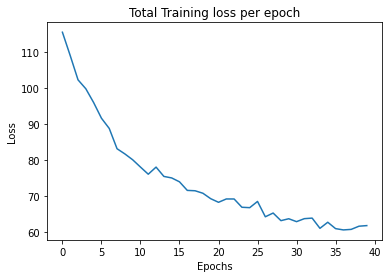

In [9]:
tot_train_losses = model.train_loss_epoch
plt.plot(tot_train_losses)
plt.title("Total Training loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

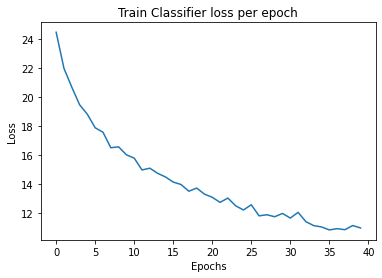

In [10]:
tot_losses = model.train_class_loss_epoch
plt.plot(tot_losses)
plt.title("Train Classifier loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

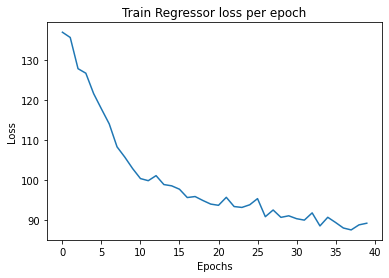

In [11]:
tot_losses = model.train_reg_loss_epoch
plt.plot(tot_losses)
plt.title("Train Regressor loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

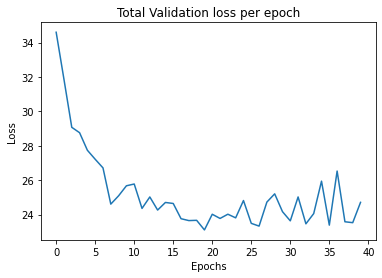

In [12]:
tot_val_losses = model.val_loss_epoch
plt.plot(tot_val_losses[1:])
plt.title("Total Validation loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

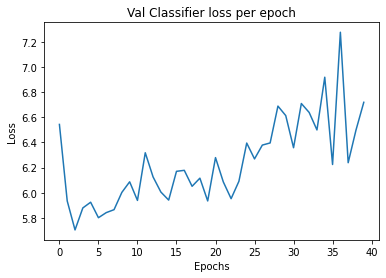

In [13]:
tot_losses = model.val_class_loss_epoch
plt.plot(tot_losses[1:])
plt.title("Val Classifier loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

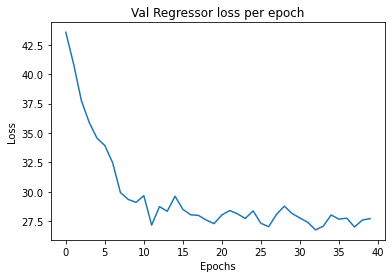

In [14]:
tot_losses = model.val_reg_loss_epoch
plt.plot(tot_losses[1:])
plt.title("Val Regressor loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [11]:
def visualizer_top_proposals(image, boxes):

    boxes = boxes.detach().cpu().numpy()
    image = image.detach().cpu().numpy()
    image = np.clip(image, 0., 255.)

    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot()

    ax.imshow(image)
    for i in range(len(boxes)):
        rect = patches.Rectangle((boxes[i][0], boxes[i][1],), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1] , fill=False,color='red')
        ax.add_patch(rect)

In [28]:
model = RPNHead()
model.load_state_dict(torch.load('model_rpn_trial.pth', map_location=device))
model.eval()
model.to(device)

RPNHead(
  (resnet50_fpn): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256,

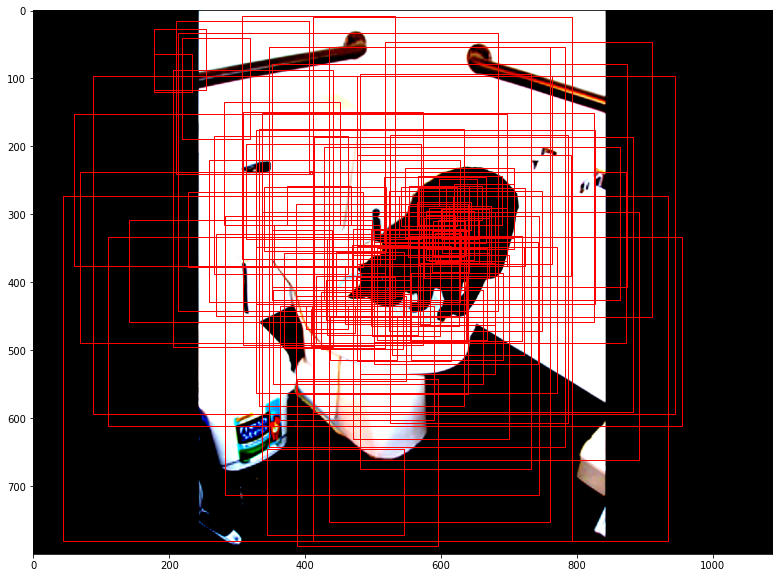

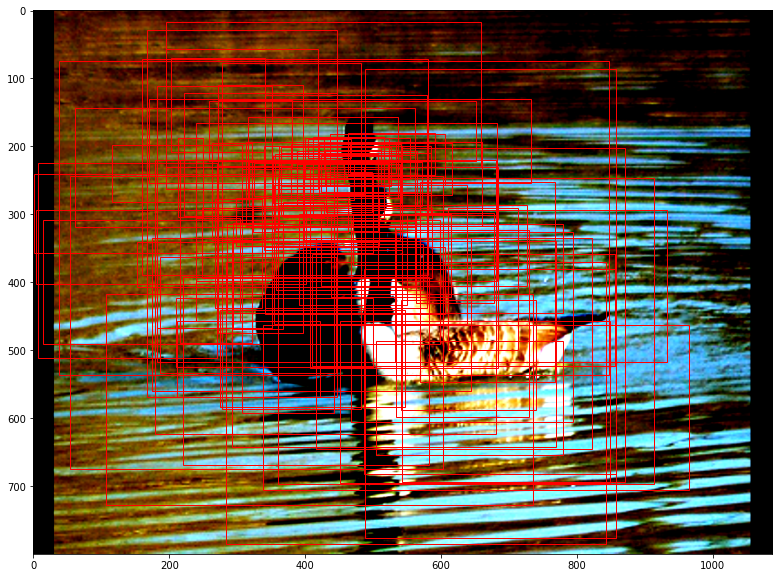

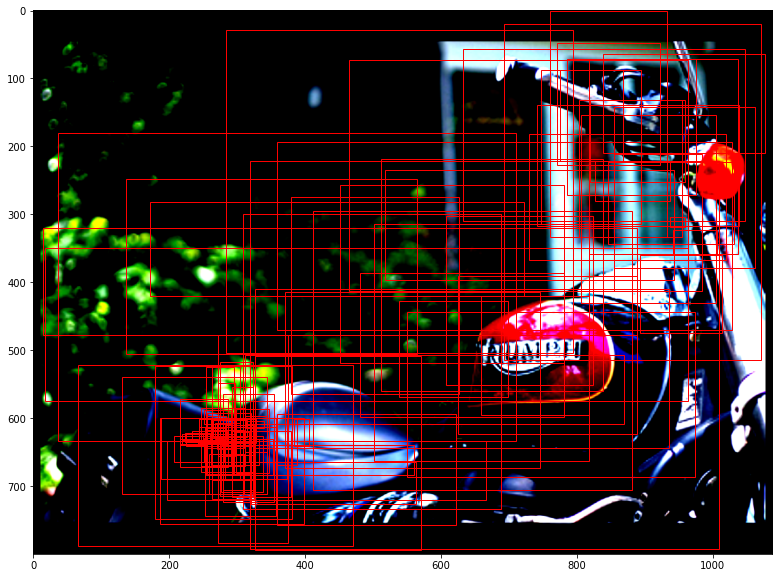

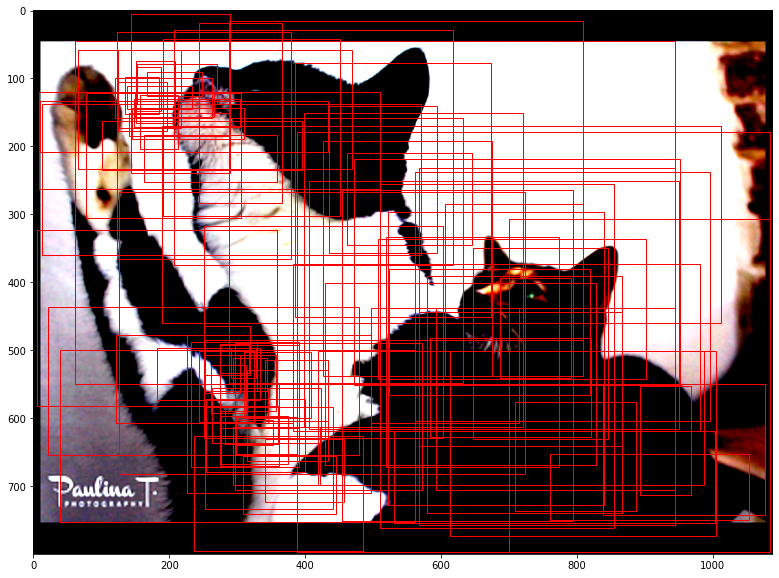

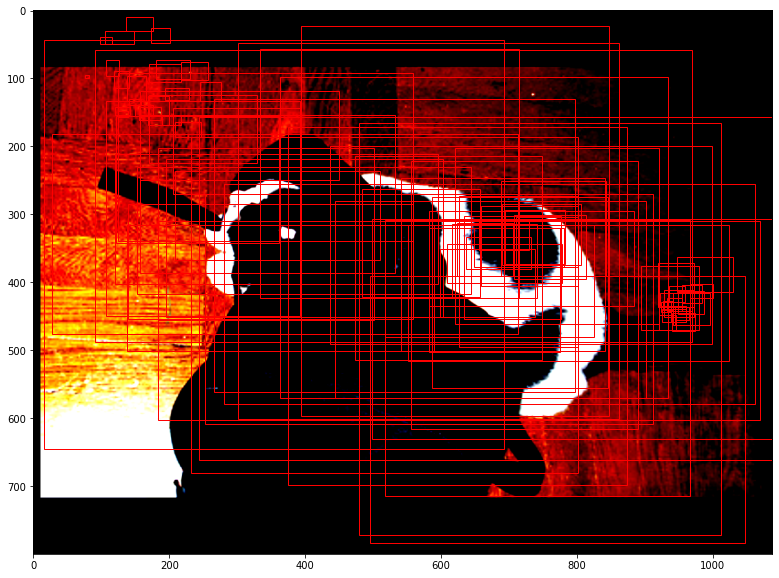

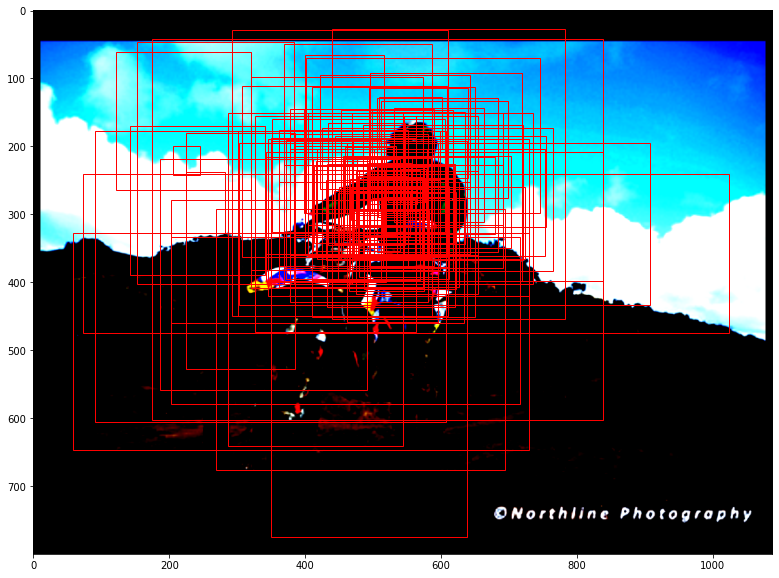

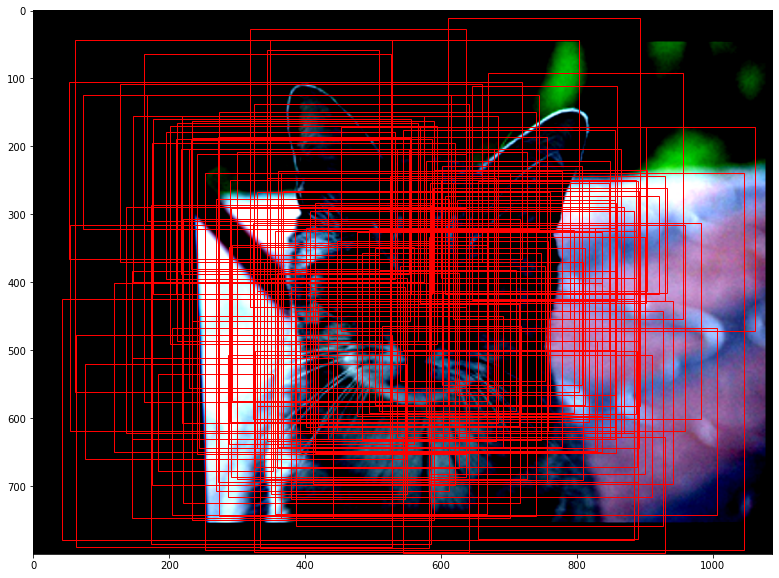

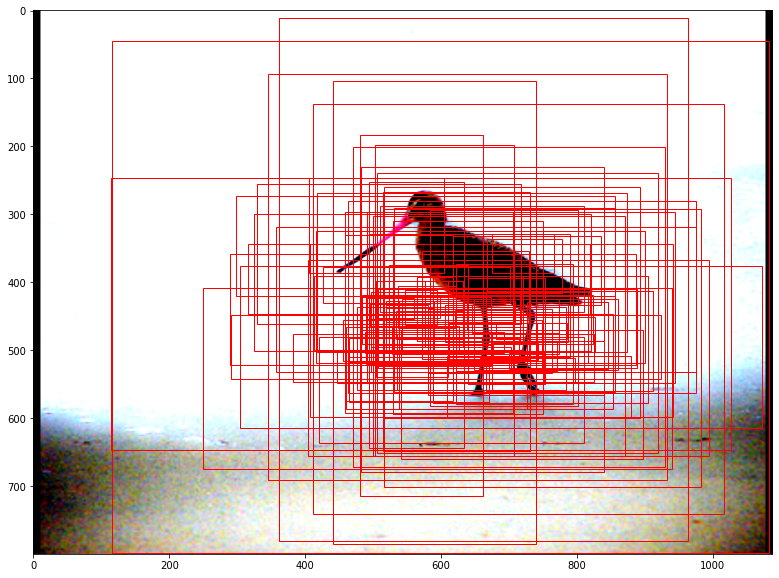

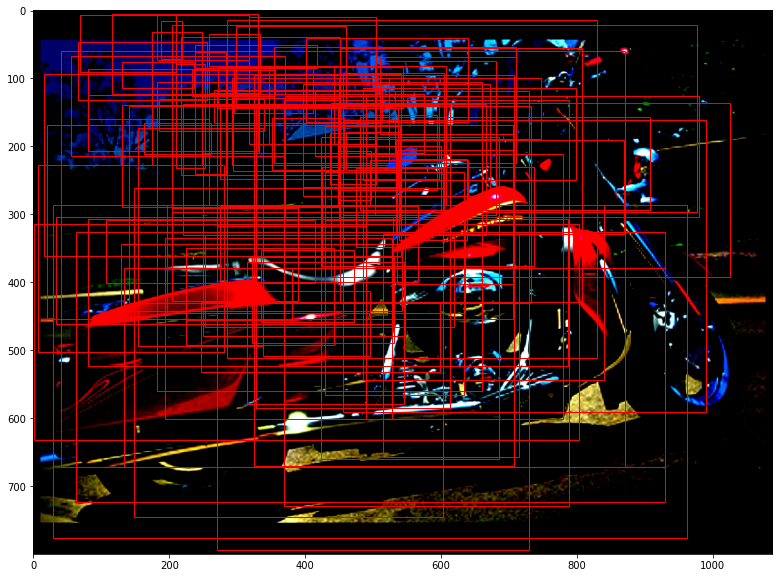

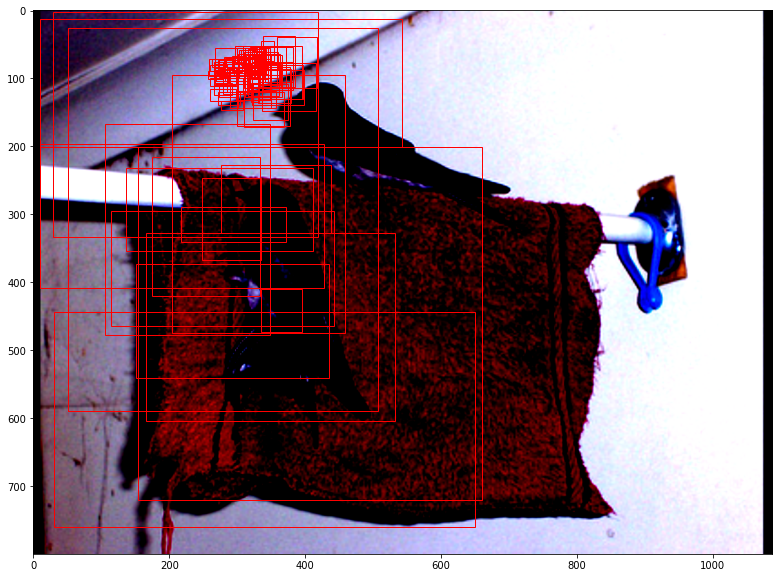

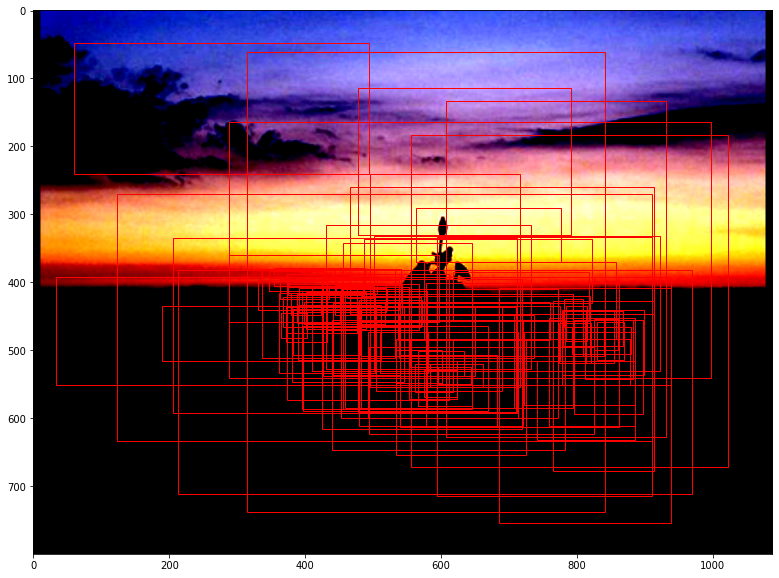

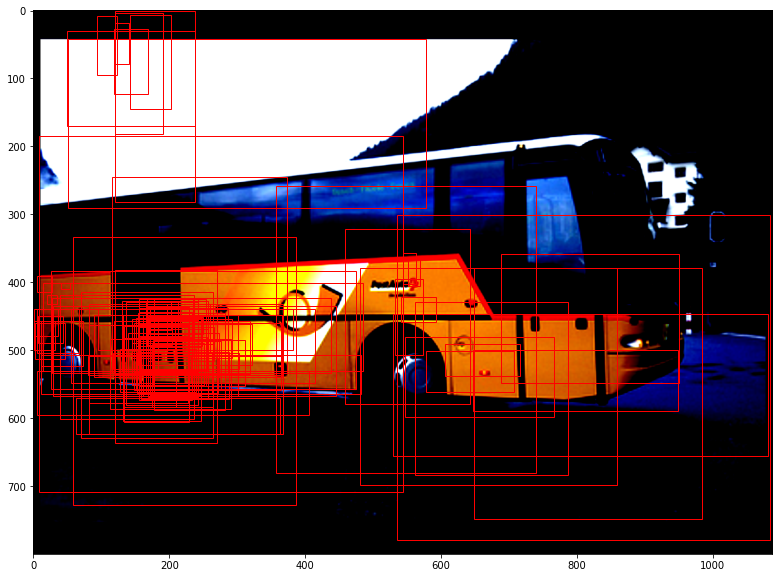

In [29]:
count = 0
temp_flag = True

for i, each_set in enumerate(train_loader):
  images=each_set['images'].to(device)
  index=each_set['index']
  bounding_boxes=each_set['bboxes']
  with torch.no_grad():
    backbone = model.resnet50_fpn(images)
    backbone_list = [backbone["0"], backbone["1"], backbone["2"], backbone["3"], backbone["pool"]]
    logits, bbox_regs = model.forward(backbone_list)

  nms_clas_list, nms_prebox_list = model.postprocess(logits, bbox_regs, IOU_thresh=0.5, keep_num_preNMS=2000, keep_num_postNMS=100)
  for i in range(4):
    visualizer_top_proposals(images[i].permute(1,2,0), nms_prebox_list[i])
    count += 1
  if count > 10 :
    temp_flag = False
    break
